In [32]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [33]:
IMAGE_SIZE=256
BATCH_SIZE=18
CHANNELS=3

In [34]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillageBell",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2475 files belonging to 2 classes.


In [35]:
class_names=dataset.class_names

In [36]:
class_names

['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy']

In [37]:
len(dataset)

138

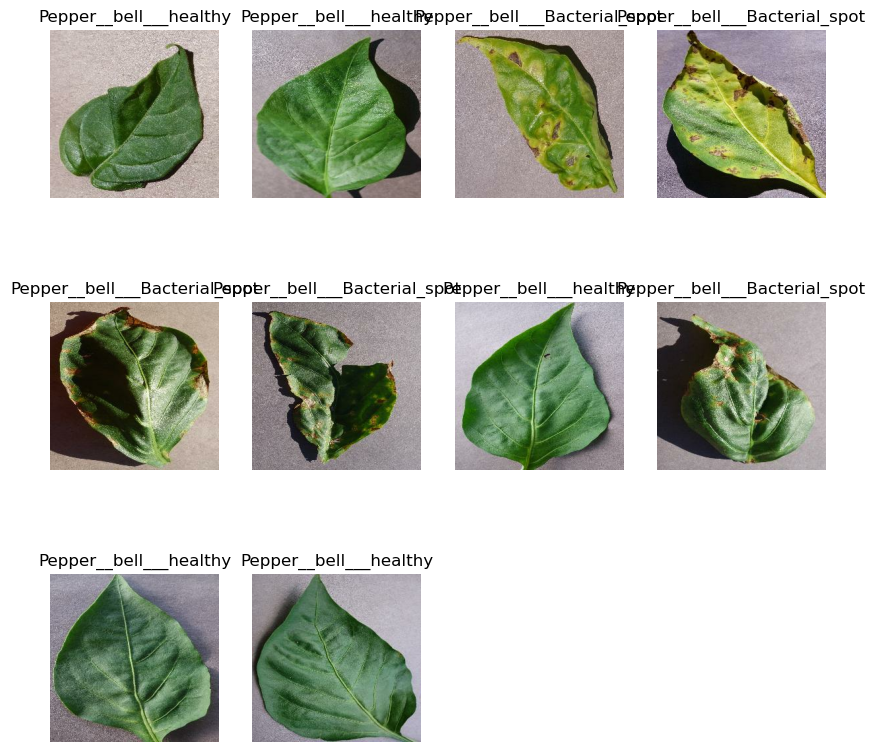

In [38]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(10):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

In [39]:
train_size=0.8
train_ds=dataset.take(54)
test_ds=dataset.skip(54)

In [40]:
val_ds=test_ds.take(6)

In [41]:
test_ds=test_ds.skip(6)

In [42]:
def get_dataset_partitions_tf(ds,train_split=.8,val_split=.1,test_split=.1,shuffle=True,shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
        
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    return train_ds,val_ds,test_ds

In [43]:
trai_ds,val_ds,test_ds=get_dataset_partitions_tf(dataset)

In [44]:
len(test_ds)

15

In [45]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [46]:
resize_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [47]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(.2),
])

In [48]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [49]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 2
model = models.Sequential([
    resize_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [50]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (18, 256, 256, 3)         0         
                                                                 
 conv2d_6 (Conv2D)           (18, 254, 254, 32)        896       
                                                                 
 max_pooling2d_6 (MaxPoolin  (18, 127, 127, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (18, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (18, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (18, 60, 60, 64)         

In [51]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [52]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=10,
)

Epoch 1/10
54/54 [==============================] - 7s 90ms/step - loss: 0.6869 - accuracy: 0.5700 - val_loss: 0.6729 - val_accuracy: 0.5812
Epoch 2/10
54/54 [==============================] - 4s 66ms/step - loss: 0.6613 - accuracy: 0.6060 - val_loss: 0.6252 - val_accuracy: 0.6410
Epoch 3/10
54/54 [==============================] - 4s 73ms/step - loss: 0.5247 - accuracy: 0.7449 - val_loss: 0.5967 - val_accuracy: 0.6709
Epoch 4/10
54/54 [==============================] - 4s 69ms/step - loss: 0.3523 - accuracy: 0.8549 - val_loss: 0.3424 - val_accuracy: 0.8590
Epoch 5/10
54/54 [==============================] - 4s 68ms/step - loss: 0.2651 - accuracy: 0.9012 - val_loss: 0.1661 - val_accuracy: 0.9316
Epoch 6/10
54/54 [==============================] - 4s 68ms/step - loss: 0.1538 - accuracy: 0.9475 - val_loss: 0.1724 - val_accuracy: 0.9444
Epoch 7/10
54/54 [==============================] - 4s 66ms/step - loss: 0.1121 - accuracy: 0.9660 - val_loss: 0.1108 - val_accuracy: 0.9573
Epoch 8/10
54

In [53]:
scores = model.evaluate(test_ds)
scores

15/15 [==============================] - 2s 22ms/step - loss: 0.0614 - accuracy: 0.9693


[0.06137964129447937, 0.969348669052124]

In [54]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 54}

In [55]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

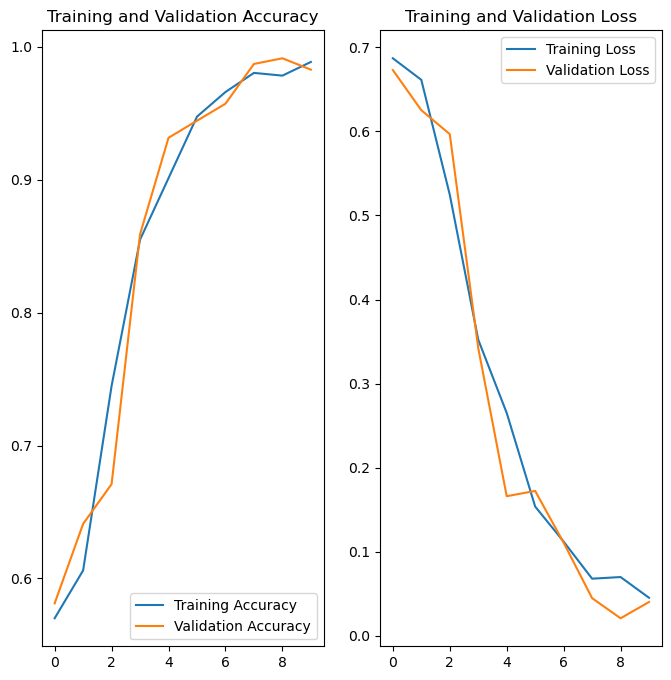

In [56]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(10), acc, label='Training Accuracy')
plt.plot(range(10), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(10), loss, label='Training Loss')
plt.plot(range(10), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Pepper__bell___healthy
1/1 [==============================] - 0s 61ms/step
predicted label: Pepper__bell___healthy


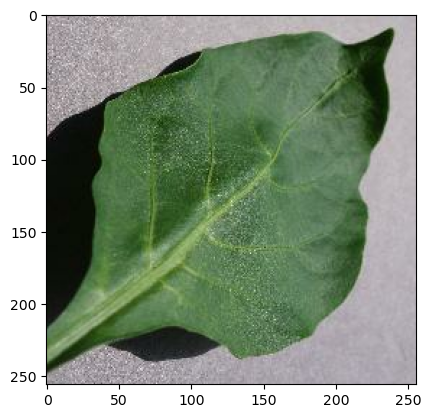

In [57]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [58]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [59]:
len(test_ds)

15

1/1 [==============================] - 0s 15ms/step


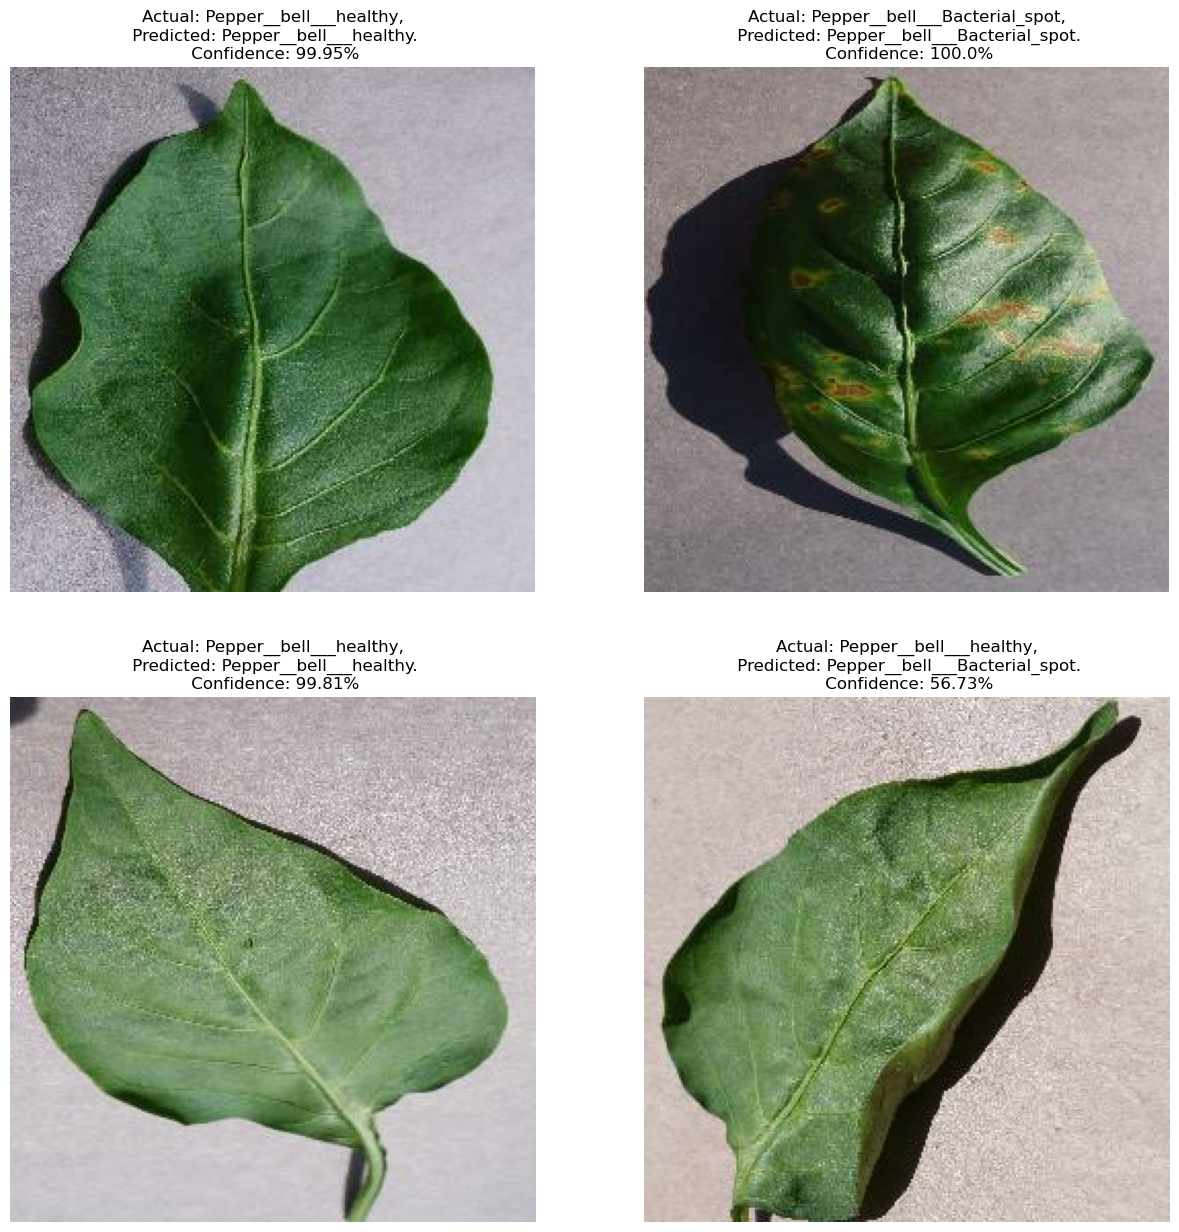

In [60]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(4):
        ax = plt.subplot(2,2, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [61]:
import os
model_version=1
model.save(f"./models/{model_version}")

INFO:tensorflow:Assets written to: ./models/1/assets


INFO:tensorflow:Assets written to: ./models/1/assets


In [62]:
model.save("./bell.h5")

/root/anaconda3/envs/py310/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
